In [2]:
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from numba import jit
from skimage import io, exposure
from skimage.filters import threshold_otsu
from scipy import interpolate as interp
from scipy import ndimage, stats, special
from scipy.optimize import minimize, brute
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import harmonic as tcharm
from spherical_analysis import * 

In [4]:
# Configure rcParams for minor ticks, grid lines
plt.rcParams['font.family'] = 'sans-serif'         # Use serif font for all text
plt.rcParams['axes.grid'] = True                   # Enable grid lines
plt.rcParams['grid.color'] = 'black'               # Set grid color (optional)
plt.rcParams['grid.linestyle'] = '--'              # Set grid line style (optional)
plt.rcParams['grid.alpha'] = 0.2                   # Set grid line transparency (optional)
plt.rcParams['xtick.minor.visible'] = True         # Enable minor ticks on x-axis
plt.rcParams['ytick.minor.visible'] = True         # Enable minor ticks on y-axis
plt.rcParams['xtick.direction'] = 'in'             # Minor ticks inward (optional)
plt.rcParams['ytick.direction'] = 'in'             # Minor ticks inward (optional)

This example notebook aims to generate the following plots:
1. Angle rotated over time
2. Radius of zebrafish over time
3. Center displacement over time
The requirements is that you have a `.json` file with the following attributes already: `center`, `radius`, `rotation_to_next`. 

plots the total angle elapsed relative to timepoint 0. The metric on $\mathrm{SO}(3)$ is defined as:
$$
\cos(\theta_{1,2}) = \frac{\mathrm{Tr}(R_1R_2^T)-1}{2}
$$

In [ ]:
# parameters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation_analysis/dataset_8"
json_name = r"dataset_8_rotation.json"

# read in stored json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))

# get the real time in hours for each frame. (Assumes data is taken at 6 hpf)
times = np.array([int(x[4:]) for x in dataset.keys()])*5 + 360

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])
    d['rotation_to_next'] = np.array(d['rotation_to_next'])

Now we plot the total angle elapsed relative to timepoint 0. The metric on $\mathrm{SO}(3)$ gives us a convienient way of getting the angle roted for a net rotation $R$:  
$$
\cos(\theta) = \frac{\mathrm{Tr}(R) - 1}{2}
$$

In [ ]:
# create list of cumulative rotation matrices starting with the identity
R_list = [np.eye(3)]

# fills list with the cumulative matrix at each index i
n = len(dataset.keys())
for i, token in enumerate(dataset.keys()):
    if i == n-1:
        break
    else:
        R_prev = R_list[i]
    R_list.append(R_prev @ dataset[token].get('rotation_to_next'))

# find the angle rotated using the above formula and convert to degrees
distances = np.zeros(len(R_list))
for i, R in enumerate(R_list):
    d = np.arccos((np.trace(R) - 1)/2)
    distances[i] = d * 180/np.pi

Text(0.5, 0, 'Timepoint')

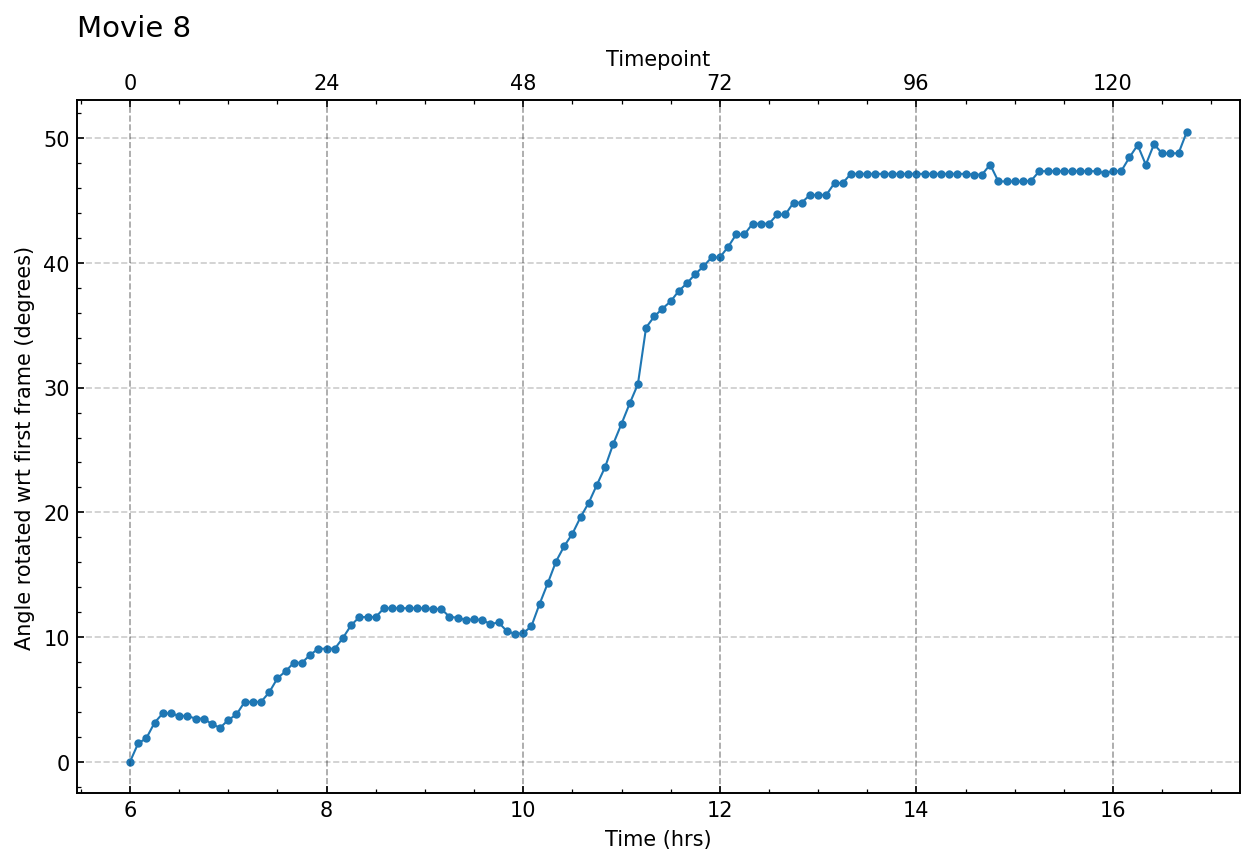

In [7]:
# Plot angle over time in hours
fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6), dpi=150)
ax1.plot(times/60, distances, marker='o', markersize=3, linewidth=1, linestyle='-')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Angle rotated wrt first frame (degrees)')
ax1.set_title('Movie 8', fontsize=14, loc='left')

# set top ticks to be the timepoints
top_times = (times-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

Now we plot the radius as a function of time.

Text(0.5, 0, 'Timepoint')

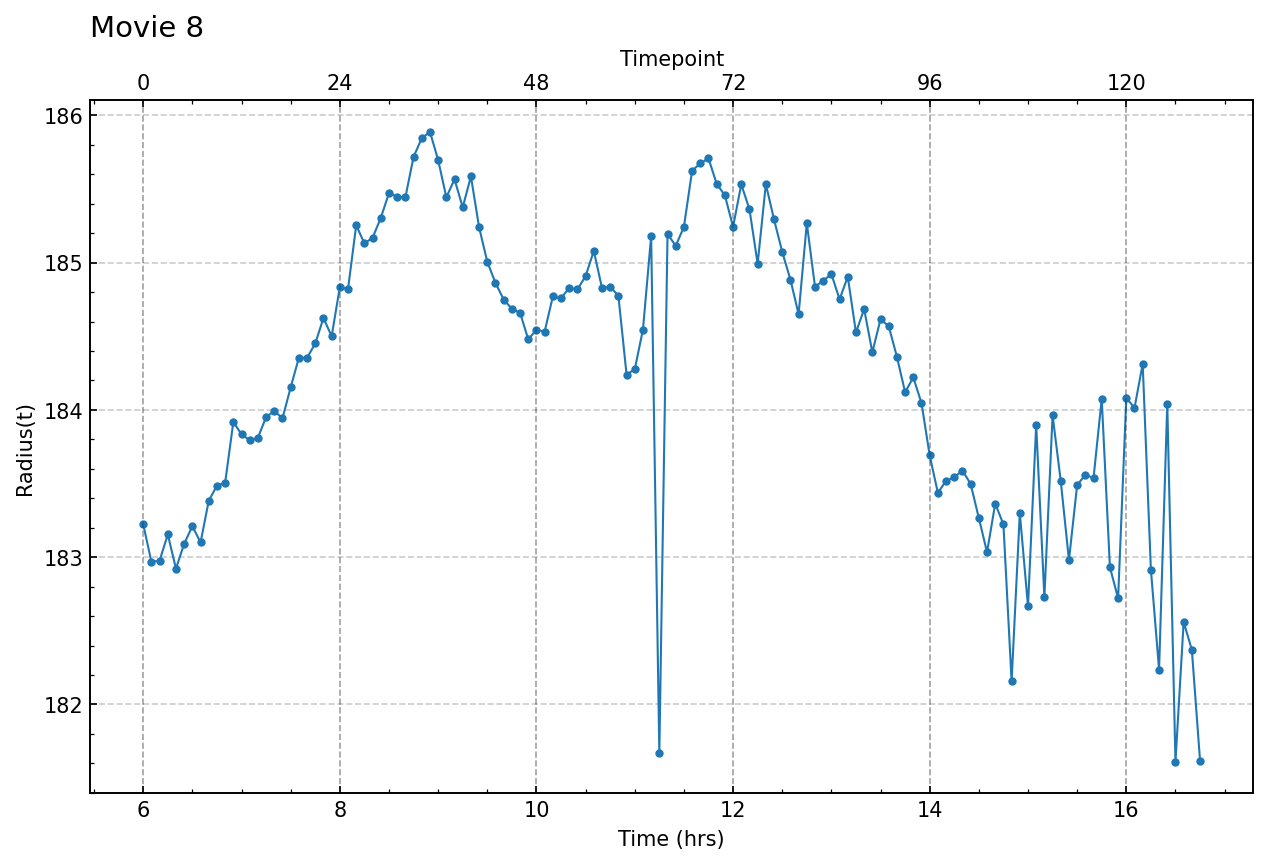

In [8]:
# extract radii from the dataset
radius_list = []
for token in dataset.keys():
    radius_list.append(dataset[token].get('radius'))

# Plot the radius over time in hours
fig, (ax1) = plt.subplots(figsize=(10,6), dpi=150)
ax1.plot(times/60, radius_list, marker='o', markersize=3, linewidth=1, linestyle='-')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Radius(t)')
ax1.set_title('Movie 8', fontsize=14, loc='left')

# set top ticks
top_times = (times-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

Now we plot the center displacement as a function of time (with respect to the center at timepoint 0).

Text(0.5, 0, 'Timepoint')

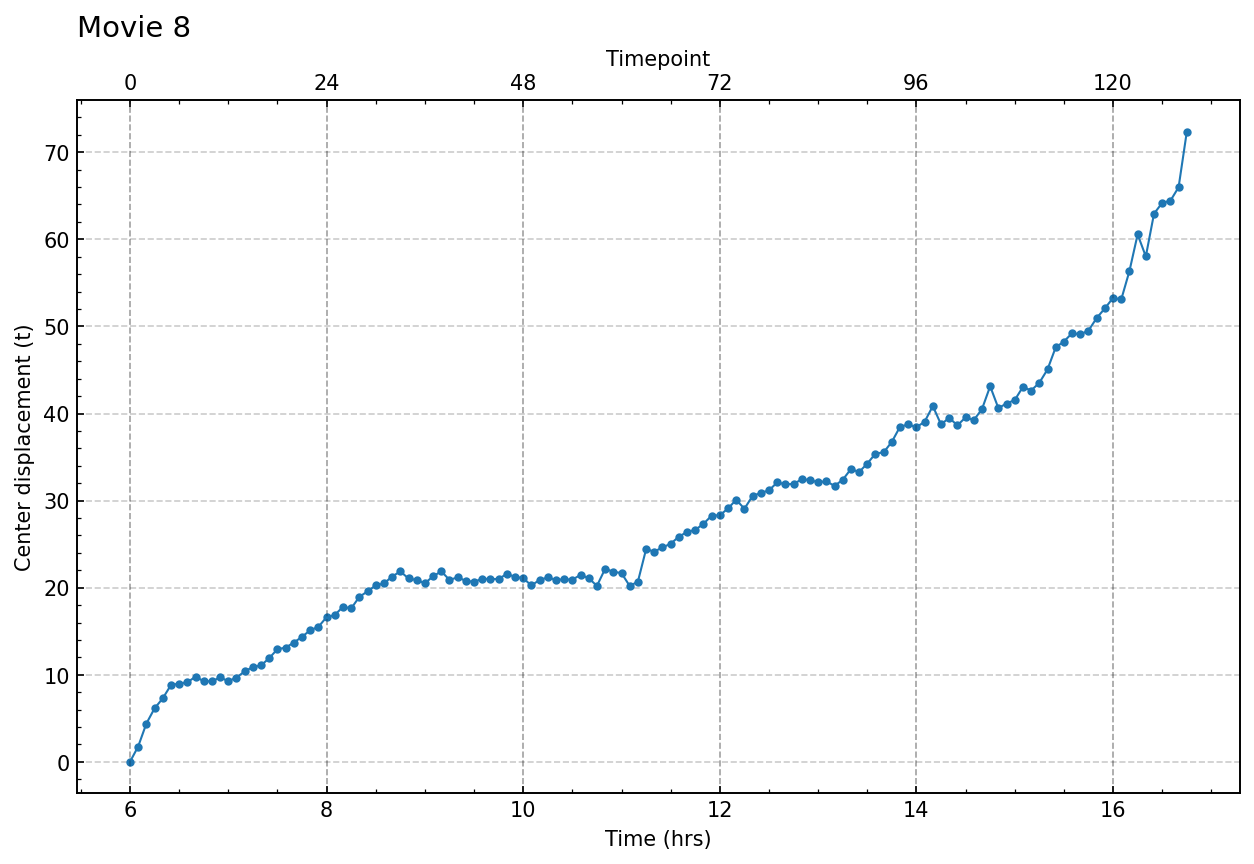

In [9]:
# gets the center displacement over time
center_displacement = []
for token in dataset.keys():
    norm = np.linalg.norm(dataset['time0']['center']-dataset[token]['center'])
    center_displacement.append(norm)

# plots center displacement over time in hours
fig, (ax1) = plt.subplots(figsize=(10,6), dpi=150)
ax1.plot(times/60, center_displacement, marker='o', markersize=3, linewidth=1, linestyle='-')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Center displacement (t)')
ax1.set_title('Movie 8', fontsize=14, loc='left')

# set top ticks
top_times = (times-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

END OF PLOTTING  

---

We can also make these plots for another dataset as well :)

In [ ]:
# read in .json
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation_analysis/dataset_5"
json_name = r"dataset_5_rotation.json"

# read in stored json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))
times = np.array([int(x[4:]) for x in dataset.keys()])*5 + 360

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])
    d['rotation_to_next'] = np.array(d['rotation_to_next'])

# create list of cumulative rotation matrices
R_list = [np.eye(3)]
n = len(dataset.keys())
for i, token in enumerate(dataset.keys()):
    if i == n-1:
        break
    else:
        R_prev = R_list[i]
    R_list.append(R_prev @ dataset[token].get('rotation_to_next'))
    #R_list.append(dataset[token].get('rotation_to_next'))

# find the angle rotated
distances = np.zeros(len(R_list))
for i, R in enumerate(R_list):
    d = np.arccos((np.trace(R) - 1)/2)
    distances[i] = d * 180/np.pi

# find radii
radius_list = []
for token in dataset.keys():
    radius_list.append(dataset[token].get('radius'))

# get centers over time
center_displacement = []
for token in dataset.keys():
    norm = np.linalg.norm(dataset['time0']['center']-dataset[token]['center'])
    center_displacement.append(norm)

Text(0.5, 0, 'Timepoint')

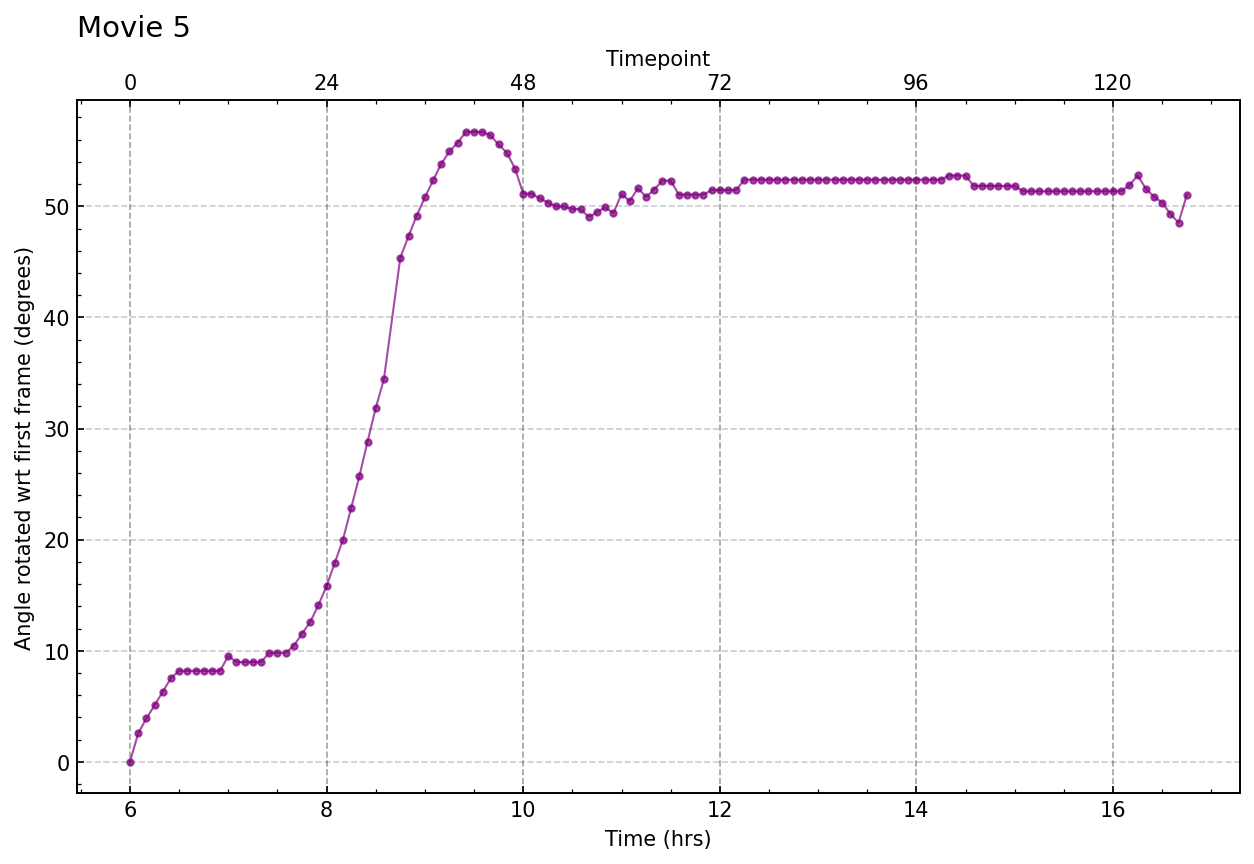

In [257]:
# Plot
fig, (ax1) = plt.subplots(ncols=1, figsize=(10,6), dpi=150)
ax1.plot(times/60, distances, marker='o', markersize=3, linewidth=1, linestyle='-', color='purple', alpha=0.7)
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Angle rotated wrt first frame (degrees)')
ax1.set_title('Movie 5', fontsize=14, loc='left')
# ax1.axvline(x=6, color='blue',alpha=0.5, linestyle='--')
# ax1.text(6.6, ax1.get_ylim()[1] * 0.9, '6 hpf', alpha=0.5, color='blue', ha='center', va='bottom', rotation=0, fontsize=12)
# set top ticks
top_times = (times[:-1]-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

Text(0.5, 0, 'Timepoint')

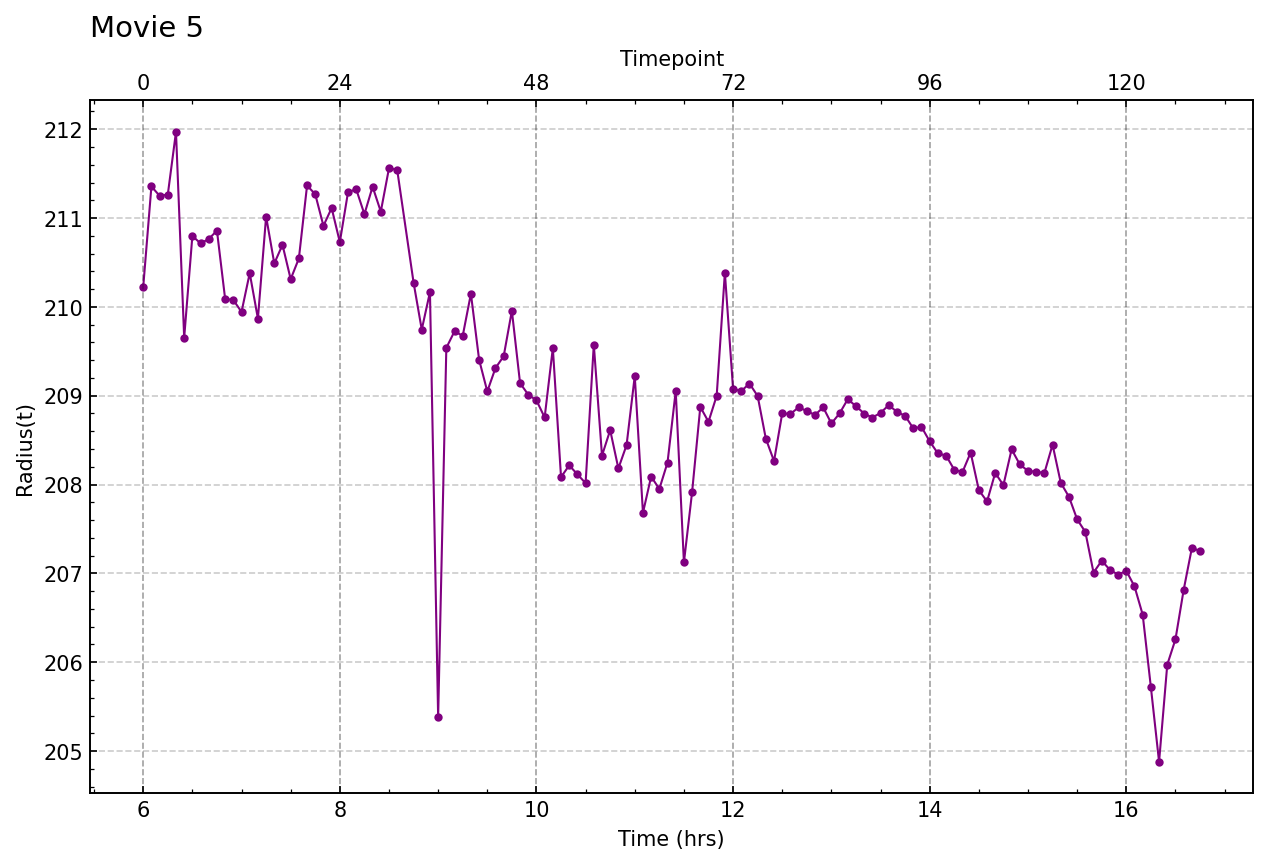

In [218]:
fig, (ax1) = plt.subplots(figsize=(10,6), dpi=150)
ax1.plot(times/60, radius_list, marker='o', markersize=3, linewidth=1, linestyle='-', color='purple')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Radius(t)')
ax1.set_title('Movie 5', fontsize=14, loc='left')
# set top ticks
top_times = (times-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

Text(0.5, 0, 'Timepoint')

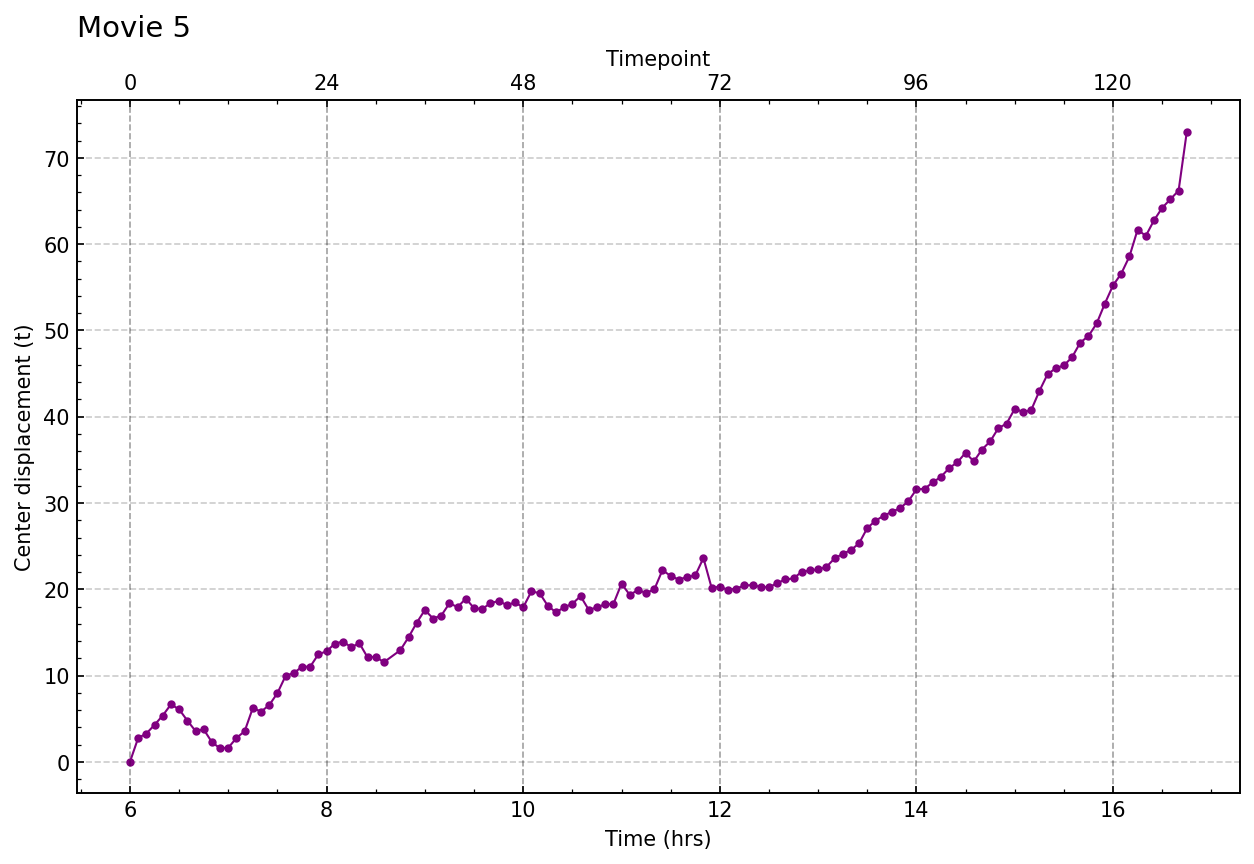

In [219]:
fig, (ax1) = plt.subplots(figsize=(10,6), dpi=150)
ax1.plot(times/60, center_displacement, marker='o', markersize=3, linewidth=1, linestyle='-', color='purple')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Center displacement (t)')
ax1.set_title('Movie 5', fontsize=14, loc='left')
# set top ticks
top_times = (times-360)/5
x_lim_rs = (np.array(ax1.get_xlim())*60-360)/5
delta = (ax1.get_xticks()[1]-ax1.get_xticks()[0])*60/5
ax_top = ax1.twiny()
ax_top.set_xlim(ax1.get_xlim())  # Make sure the limits match
ax_top.set_xticks(np.arange(0, x_lim_rs[-1], delta)) # some conversion bs. step size is 2 hrs / 5
ax_top.set_xlim(*x_lim_rs)
ax_top.set_xlabel('Timepoint')

---